In [ ]:
import json
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import spacy as sp
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from spacy.tokens import Doc
from sklearn.utils import resample
from datetime import datetime, timedelta

%matplotlib inline

In [2]:
DATETIME_FORMAT = '%Y%m%dT%H%M'

def generate_timestamps(start_date, end_date, interval_days=1):
    start_datetime = datetime.strptime(start_date, DATETIME_FORMAT) + timedelta(minutes=1)
    end_datetime = datetime.strptime(start_date, DATETIME_FORMAT) + timedelta(days=1)
    timestamps = [] # a list of start and end timestamps (a tuple for each day)

    while end_datetime <= datetime.strptime(end_date, DATETIME_FORMAT):
        timestamps.append((start_datetime.strftime(DATETIME_FORMAT), end_datetime.strftime(DATETIME_FORMAT)))
        start_datetime += timedelta(days=1)
        end_datetime += timedelta(days=1)
    return timestamps

# Example usage
start_date = '20240801T0000'
end_date = '20240810T0000'
timestamps = generate_timestamps(start_date, end_date)
timestamps

[('20240801T0001', '20240802T0000'),
 ('20240802T0001', '20240803T0000'),
 ('20240803T0001', '20240804T0000'),
 ('20240804T0001', '20240805T0000'),
 ('20240805T0001', '20240806T0000'),
 ('20240806T0001', '20240807T0000'),
 ('20240807T0001', '20240808T0000'),
 ('20240808T0001', '20240809T0000'),
 ('20240809T0001', '20240810T0000')]

In [36]:
# Vantage news API Key
with open('./env', mode='r', encoding='utf-8') as f:
    api_key = f.readline().split('=')[-1]

i = 0

# 30 days of financial news (FREE tier only allows 25 requests/day, hence, only 25 days of data is collected).
for t in timestamps:
    time_from, time_to = t[0], t[1]

    # ticker = 'MSFT'
    url = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&time_from={time_from}&time_to={time_to}&limit=1000&apikey={api_key}'
    r = requests.get(url, headers={
        'User-Agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.75 Safari/537.36",
        'Accept-Language': 'en-US,en;h=0.9'})
    if r.status_code == 200:
        print(f'{time_from} - {time_to}')
        data = r.json()
    else:
        break
    # UNCOMMENT TO SAVE JSON, intended for one time download only.
    # with open(f'./data_2024/data_{time_from}_{time_to}.json', 'w') as fp:
    #     json.dump(data, fp)


20240801T0001 - 20240802T0000
20240802T0001 - 20240803T0000
20240803T0001 - 20240804T0000
20240804T0001 - 20240805T0000
20240805T0001 - 20240806T0000
20240806T0001 - 20240807T0000
20240807T0001 - 20240808T0000
20240808T0001 - 20240809T0000
20240809T0001 - 20240810T0000


In [62]:
def read_json_files(dir: str, fname_filter=None) -> list:
    json_fnames = []
    for (_, _, fnames) in os.walk(dir):
        json_fnames.extend(fnames)
        break  # ensure only top level json files are read.

    filter_predicate = lambda name: name.startswith(fname_filter) and name.endswith('.json') if fname_filter else lambda \
            name: name.startswith(filter)
    json_fnames = list(filter(filter_predicate, json_fnames))

    json_data = []
    for fname in json_fnames:
        with open(f'{dir}/{fname}', 'r') as json_file:
            json_data.append(json.load(json_file))
    return json_data


json_data = read_json_files('./data_2024', 'data')

Print the top-level and second-level structure of a json element.

In [63]:
keys = json_data[0].keys()
for k in list(keys):
    value = json_data[0][k]
    if type(value) == dict:
        print(f'{k}:')
        for attr in value.keys():
            print(f'\t{attr}')
    elif type(value) == list:
        print(f'{k}[0]:')
        print(f'\t{list(value[0].keys())}')
    else:
        print(f'{k}')


items
sentiment_score_definition
relevance_score_definition
feed[0]:
	['title', 'url', 'time_published', 'authors', 'summary', 'banner_image', 'source', 'category_within_source', 'source_domain', 'topics', 'overall_sentiment_score', 'overall_sentiment_label', 'ticker_sentiment']


In [64]:
def parse_vantage_api_data(json_data: list) -> pd.DataFrame:
    df_list = []
    for json_dict in json_data:
        for item in json_dict['feed']:
            item_dict = {'title': item['title'], 'time_published': item['time_published'], 'summary': item['summary'],
                         'overall_sentiment_label': item['overall_sentiment_label'],
                         'overall_sentiment_score': item['overall_sentiment_score'],
                         'ticker_sentiment': item['ticker_sentiment']}
            df_list.append(item_dict)
    return pd.DataFrame(df_list)


data_df = parse_vantage_api_data(json_data)

In [65]:
data_df.head()

,title,time_published,summary,overall_sentiment_label,overall_sentiment_score,ticker_sentiment
0,Aleph Group Acquires Entravision's Digital Adv...,20240702T000000,Aleph Group Acquires Entravision's Digital Adv...,Somewhat-Bullish,0.317000,"[{'ticker': 'MSFT', 'relevance_score': '0.0683..."
1,"Nvidia Is a Top AI Stock, but Don't Ignore The...",20240702T000000,Investors shouldn't turn a blind eye to the ho...,Somewhat-Bullish,0.171278,"[{'ticker': 'MSFT', 'relevance_score': '0.0459..."
2,Celebrate Milestone: Fast Forex VPS Introduces...,20240702T000000,"SINGAPORE, July 2, 2024 /PRNewswire/ -- Fast F...",Bullish,0.603762,[]
3,WTW announces leadership change in Australia a...,20240702T000000,James Baum is appointed as Head of Australia a...,Bullish,0.489207,"[{'ticker': 'AON', 'relevance_score': '0.17585..."
4,Bitfarms mined 21% more Bitcoin in June amid R...,20240701T234906,Bitfarms increased its online hashrate to 10.4...,Neutral,-0.038424,"[{'ticker': 'BITF', 'relevance_score': '0.9191..."


In [66]:
data_df["news"] = data_df["title"].str.cat(data_df["summary"])

In [68]:
# fix class imbalance
BEARISH = 'Bearish'
SOMEWHAT_BEARISH = 'Somewhat-Bearish'
NEUTRAL = 'Neutral'
SOMEWHAT_BULLISH = 'Somewhat-Bullish'
BULLISH = 'Bullish'

bearish_df = data_df[
    (data_df['overall_sentiment_label'] == BEARISH) | (data_df['overall_sentiment_label'] == SOMEWHAT_BEARISH)]

neutral_df = data_df[data_df['overall_sentiment_label'] == NEUTRAL]

bullish_df = data_df[
    (data_df['overall_sentiment_label'] == BULLISH) | (data_df['overall_sentiment_label'] == SOMEWHAT_BULLISH)]

print(f'{BEARISH} & {SOMEWHAT_BEARISH}: {len(bearish_df)}')
print(f'{NEUTRAL}: {len(neutral_df)}')
print(f'{BULLISH} & {SOMEWHAT_BULLISH}: {len(bullish_df)}')

neutral_df = resample(neutral_df, replace=False, n_samples=1000, random_state=42)
bullish_df = resample(bullish_df, replace=False, n_samples=1000, random_state=42)

print("\nAfter resampling:")
print("====================================================")
print(f'{BEARISH} & {SOMEWHAT_BEARISH}: {len(bearish_df)}')
print(f'{NEUTRAL}: {len(neutral_df)}')
print(f'{BULLISH} & {SOMEWHAT_BULLISH}: {len(bullish_df)}')

balanced_df = pd.concat([bearish_df, bearish_df, neutral_df, bullish_df])
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

Bearish & Somewhat-Bearish: 624
Neutral: 12641
Bullish & Somewhat-Bullish: 21130

After resampling:
Bearish & Somewhat-Bearish: 624
Neutral: 1000
Bullish & Somewhat-Bullish: 1000


In [69]:
print(balanced_df.shape)

(3248, 7)


Parse, tokenize, and lemmatize

In [70]:
MAX_WORDS = 64
MIN_WORDS = 4

nlp = sp.load('en_core_web_sm', disable=['ner', 'parser'])  # NER not required for this task


def cleaning(doc: Doc) -> str:
    # Lemmatize and remove stopwords
    # txt = [token.lemma_ for token in doc if not token.is_stop]
    # OPT-2: Lemmatize but keep stopwords
    txt = [token.lemma_ for token in doc]
    # Filter news with fewer words

    return ' '.join(txt)


brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in balanced_df['news'])

In [71]:
cleaned_txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=2500, n_process=-1)]

In [72]:
df_cleaned = pd.DataFrame(
    {'cleaned_text': cleaned_txt, 'overall_sentiment_label': balanced_df['overall_sentiment_label'],
     'overall_sentiment_score': balanced_df['overall_sentiment_score']})
df_cleaned.shape

(3248, 3)

In [73]:
df_cleaned.head()

,cleaned_text,overall_sentiment_label,overall_sentiment_score
0,pdd vs mmm which stock be the well value optio...,Bullish,0.468114
1,why be uber share high today uber technologies...,Bullish,0.391184
2,quantumscape stock be down on recession fear b...,Bearish,-0.355271
3,hurricane beryl be a warning this storm season...,Somewhat-Bearish,-0.190613
4,why rivian stock be slump todaya recession wou...,Bearish,-0.373020


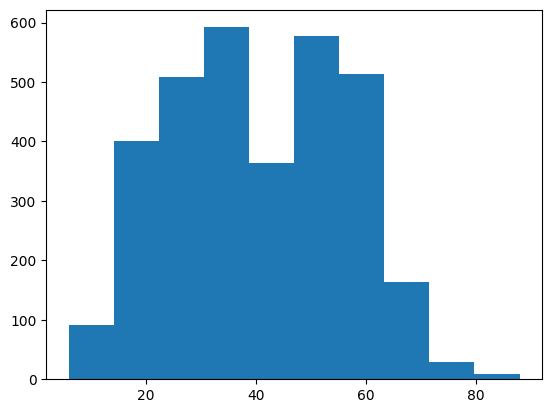

In [74]:
# Length distribution of each summary

text_len_dist = np.asarray([0 if sen is None else len(sen.split()) for sen in df_cleaned['cleaned_text']])

_ = plt.hist(text_len_dist)

In [75]:
print(f"Mean: {np.mean(text_len_dist)}")
print(f"Median: {np.median(text_len_dist)}")
print(f"Max: {np.max(text_len_dist)}")

Mean: 40.48029556650246
Median: 39.0
Max: 88


In [76]:
df_cleaned['overall_sentiment_label'].unique()

array(['Bullish', 'Bearish', 'Somewhat-Bearish', 'Neutral',
       'Somewhat-Bullish'], dtype=object)

In [77]:
label_map = {
    'Bearish': 0,
    'Somewhat-Bearish': 1,
    'Neutral': 2,
    'Somewhat-Bullish': 3,
    'Bullish': 4,
}

for key in list(label_map.keys()):
    df_cleaned.loc[df_cleaned['overall_sentiment_label'] == key, 'overall_sentiment_label'] = label_map[key]

df_cleaned['overall_sentiment_label'] = df_cleaned['overall_sentiment_label']
df_cleaned.dropna(inplace=True)
df_cleaned.reset_index(drop=True, inplace=True)

In [78]:
df_cleaned.head()

,cleaned_text,overall_sentiment_label,overall_sentiment_score
0,pdd vs mmm which stock be the well value optio...,4,0.468114
1,why be uber share high today uber technologies...,4,0.391184
2,quantumscape stock be down on recession fear b...,0,-0.355271
3,hurricane beryl be a warning this storm season...,1,-0.190613
4,why rivian stock be slump todaya recession wou...,0,-0.373020


In [79]:
# Preprocess News dataset
def doc_level_preprocess(doc):
    tokens = set(doc.split(" ")[:MAX_WORDS])
    if '' in tokens:
        tokens.remove('')
    return tokens


# Categorical
df_train = [(x, df_cleaned['overall_sentiment_label'][i]) for i, x in
            enumerate(map(doc_level_preprocess, df_cleaned['cleaned_text']))
            if len(x) >= MIN_WORDS]

# Regression
# df_train = [(x, df_cleaned['overall_sentiment_score'][i]) for i, x in
#             enumerate(map(doc_level_preprocess, df_cleaned['cleaned_text']))
#             if len(x) >= MIN_WORDS]

Loading Glove vectors

In [80]:
def read_glove_vectors(path):
    glo_dict = {}
    with open(path, mode='r', encoding='utf8') as file:
        for line in file.readlines():
            line = line.split(" ")
            glo_dict[line[0]] = np.asarray(line[1:], dtype=np.float32)
    return glo_dict


GLOVE_PATH = "./data/glove.6B.100d.txt"
glo_dict = read_glove_vectors(GLOVE_PATH)

In [81]:
# Finding common words

vant_vocab_set = set()

for news in df_train:
    vant_vocab_set.update(news[0])  # news[0] is news, news[1] is label
glove_set = set(glo_dict.keys())
glove_set &= vant_vocab_set


In [82]:
TRAINABLE_EMB_LAYER = True
glove_token_arr = np.array(sorted(list(glove_set)))

# single numpy array before building a torch Tensor
glove_vec_arr = np.asarray([glo_dict[token] for token in glove_token_arr], dtype=np.float32)
glove_emb_layer = nn.Embedding.from_pretrained(torch.Tensor(glove_vec_arr))
glove_emb_layer.weight.requires_grad = TRAINABLE_EMB_LAYER
# only relevant glove embeddings are in memory.
glove_vec_arr.shape

(8184, 100)

In [83]:
import torch

print(f'CUDA: {torch.cuda.is_available()}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {device}')

CUDA: True
DEVICE: cuda:0


In [84]:
# build an index array for fetching the word vectors
def doc2ind(doc, max_dim=100):
    token_idx = np.minimum(np.searchsorted(glove_token_arr, doc), len(glove_token_arr) - 1)
    valid_tokens = glove_token_arr[token_idx] == doc
    # pre-padding the vector then filling it with valid indices
    indices = np.zeros(max_dim, dtype=np.int32)
    indices[:sum(valid_tokens)] = token_idx[valid_tokens]
    return indices


# vant_word_embeddings indices
X = torch.LongTensor([doc2ind(list(doc[0]), max_dim=MAX_WORDS) for doc in df_train])
# labels
y = torch.Tensor(np.array([doc[1] for doc in df_train], dtype=np.int32))

In [85]:
print(f'X: {X.shape}')
print(f'y: {y.shape}')

X: torch.Size([3248, 64])
y: torch.Size([3248])


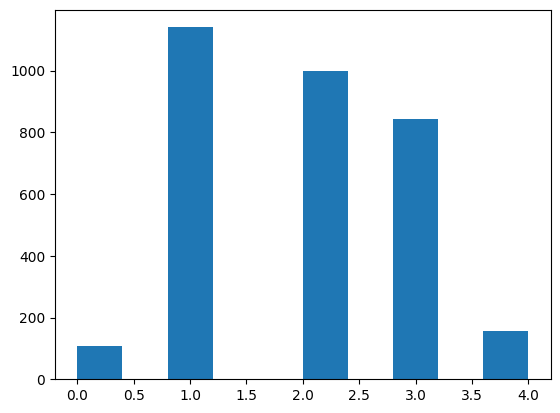

In [86]:
_ = plt.hist(y)

In [49]:
# X_train and X_test are indices and not the actual glove word embeddings.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=54)

# To GPU
X_train = torch.Tensor(X_train).to(device)
X_test = torch.Tensor(X_test).to(device)

y_train = torch.Tensor(y_train).to(device)
y_test = torch.Tensor(y_test).to(device)

# Finally Embedding layer to the GPU
glove_emb_layer = glove_emb_layer.to(device)

_, cts = np.unique(torch.Tensor.cpu(y_train), return_counts=True)
class_weights = 1.0 / cts
class_weights /= class_weights.sum()
class_weights = torch.Tensor(class_weights).to(device)

In [50]:
class_weights

tensor([0.6129, 0.0569, 0.0398, 0.0477, 0.2427], device='cuda:0')

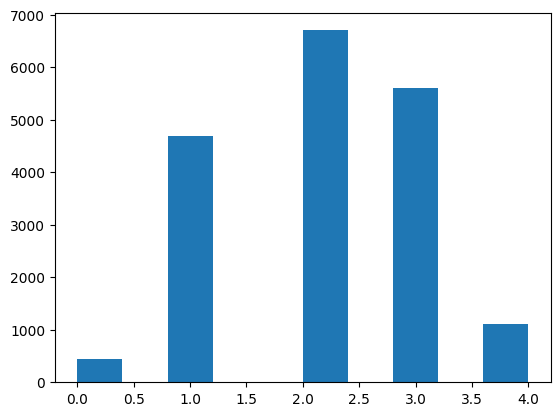

In [51]:
_ = plt.hist(torch.Tensor.cpu(y_train))

In [52]:
BATCH_SIZE = 8192
NUM_LABELS = len(np.unique(y))


# NUM_LABELS = 1 # regression model


def setup_model(num_classes=NUM_LABELS, emb_layer=glove_emb_layer):
    return nn.Sequential(
        emb_layer,
        nn.Flatten(),
        nn.Linear(MAX_WORDS * 100, 2048),
        nn.Dropout(0.05),
        nn.LeakyReLU(),
        nn.Linear(2048, 512),
        nn.Dropout(0.05),
        nn.LeakyReLU(),
        nn.Linear(512, 64),
        nn.LeakyReLU(),
        nn.Linear(64, num_classes),
        nn.Softmax(dim=1)
    )

In [53]:
def train_model(model, X_train, X_test, y_train, y_test, n_epochs=50, lr=0.0001):
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    batch_per_epoch = len(X_train) // BATCH_SIZE

    tr_loss_hist = np.zeros((n_epochs,), dtype=np.float32)
    ts_loss_hist = np.zeros((n_epochs,), dtype=np.float32)
    ts_acc_hist = np.zeros((n_epochs), dtype=np.float32)

    model.train(mode=True)
    for epoch in range(n_epochs):
        print(f'*** EPOCH {epoch} ***')
        tr_loss = 0.

        for i in range(batch_per_epoch):
            st = i * BATCH_SIZE
            X_batch = X_train[st:st + BATCH_SIZE]
            y_batch = y_train[st:st + BATCH_SIZE]
            # predict / forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch.to(torch.uint8))
            tr_loss += loss
            # tune / backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()

        tr_loss /= batch_per_epoch
        # test
        with torch.no_grad():
            y_pred = model(X_test)
        acc = float((y_pred.argmax(axis=1) == y_test).to(torch.float64).mean())
        test_loss = loss_fn(y_pred, y_test.to(torch.uint8))
        print("Train Loss {:.2f}".format(tr_loss))
        print("Test Loss {:.2f}".format(test_loss))
        print("Test Accuracy {:.2f} \n".format(acc))
        tr_loss_hist[epoch] = tr_loss
        ts_loss_hist[epoch] = test_loss
        ts_acc_hist[epoch] = acc
    return tr_loss_hist, ts_loss_hist, ts_acc_hist

In [54]:
model = setup_model(num_classes=NUM_LABELS)
model = model.to(device)
print(model)

Sequential(
  (0): Embedding(22823, 100)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=6400, out_features=2048, bias=True)
  (3): Dropout(p=0.05, inplace=False)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Linear(in_features=2048, out_features=512, bias=True)
  (6): Dropout(p=0.05, inplace=False)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=512, out_features=64, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=64, out_features=5, bias=True)
  (11): Softmax(dim=1)
)


In [55]:
tr_loss_hist, ts_loss_hist, ts_acc_hist = train_model(model, X_train, X_test, y_train, y_test, n_epochs=200)

*** EPOCH 0 ***
Train Loss 1.61
Test Loss 1.61
Test Accuracy 0.12 

*** EPOCH 1 ***
Train Loss 1.61
Test Loss 1.60
Test Accuracy 0.19 

*** EPOCH 2 ***
Train Loss 1.60
Test Loss 1.60
Test Accuracy 0.20 

*** EPOCH 3 ***
Train Loss 1.60
Test Loss 1.60
Test Accuracy 0.21 

*** EPOCH 4 ***
Train Loss 1.59
Test Loss 1.59
Test Accuracy 0.23 

*** EPOCH 5 ***
Train Loss 1.58
Test Loss 1.58
Test Accuracy 0.20 

*** EPOCH 6 ***
Train Loss 1.57
Test Loss 1.57
Test Accuracy 0.20 

*** EPOCH 7 ***
Train Loss 1.56
Test Loss 1.56
Test Accuracy 0.21 

*** EPOCH 8 ***
Train Loss 1.54
Test Loss 1.55
Test Accuracy 0.21 

*** EPOCH 9 ***
Train Loss 1.53
Test Loss 1.53
Test Accuracy 0.21 

*** EPOCH 10 ***
Train Loss 1.51
Test Loss 1.52
Test Accuracy 0.23 

*** EPOCH 11 ***
Train Loss 1.49
Test Loss 1.50
Test Accuracy 0.23 

*** EPOCH 12 ***
Train Loss 1.47
Test Loss 1.49
Test Accuracy 0.25 

*** EPOCH 13 ***
Train Loss 1.46
Test Loss 1.48
Test Accuracy 0.26 

*** EPOCH 14 ***
Train Loss 1.44
Test Loss 1

In [56]:
MODEL_NAME = "2048_class_wts_ep_200"
torch.save(model, f"./models/{MODEL_NAME}")

In [57]:
training_hist = pd.DataFrame.from_dict({'train_loss': tr_loss_hist, 'test_loss' : ts_loss_hist, 'accuracy': ts_acc_hist})
training_hist.to_csv(f'./models/{MODEL_NAME+'_training_history'}.csv')

In [ ]:
# dense_emb = glove_emb_layer.weight[X].detach().numpy()
# dense_emb = np.reshape(dense_emb, (dense_emb.shape[0], MAX_WORDS * 100))
# dense_emb.shape

## Evaluate

In [87]:
MODEL_NAME = "2048_class_wts_ep_200"
eval_model = torch.load(f"./models/{MODEL_NAME}")

In [88]:
# To GPU
X = torch.Tensor(X).to(device)
y = torch.Tensor(y).to(device)

# Finally Embedding layer to the GPU
glove_emb_layer = glove_emb_layer.to(device)
eval_model = eval_model.to(device)

In [90]:
with torch.no_grad():
    y_pred = torch.Tensor.cpu(eval_model(X))
    acc = accuracy_score(torch.Tensor.cpu(y), y_pred.argmax(axis=1))
    f1 = f1_score(torch.Tensor.cpu(y), y_pred.argmax(axis=1), average='macro')
print(f'Accuracy: {acc}')
print(f'Macro F1 score: {f1}')

Accuracy: 0.2749384236453202
Macro F1 score: 0.15596017121531539
